**Train/Test/Val Data Split**

We adopt the same portion (60% training, 20% validation, and 20% tes) as we used in the classifier training.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# !pip install demoji
import demoji
import pandas as pd
import random
from dataclasses import dataclass
import numpy as np
import torch
# import seaborn as sns
import transformers
import json
import glob
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, AUROC, F1Score, Precision, Recall
from itertools import chain

# import tensorflow as tf
# from tensorflow import keras

# from transformers import RobertaTokenizerFast
# from transformers import TFRobertaModel

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix



/home/tbrow51/.conda/envs/transformers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_script(seed: int):
    # set torch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # set numpy seed
    np.random.seed(seed)
    print("seed set...")
    
SEED = 13
seed_script(SEED)

seed set...


In [3]:
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using {device} device...")

using cuda device...


In [4]:
file_path = "/opt/localdata/Data/bea/nlp/bmi550/project/sentiment_data/combined_tweets.csv"
df = pd.read_csv(file_path)
df

,index,Unnamed: 0.1,Unnamed: 0,screen_name,created_at,sampled_at,id_str,text,tweet_id,location,keyword,collection_site,prediction,binary_pred,general_sentiment,provider_sentiment
0,53922,32828,32828,nomadicism,2009-12-15 04:28:45+00:00,2022-04-17 15:45:21+00:00,9.691240e+07,<user> i sure as fuck am. i'm in texas visitin...,1.515720e+18,NaN,chronicpain,Emory,0.969140,True,0.0,0.0
1,73070,51976,51976,jaexjoongs,2009-04-02 14:03:23+00:00,2022-03-24 22:23:16+00:00,2.834280e+07,so tired of chronic pain and this is the most ...,1.507120e+18,"Cleveland, OH - Parma Heights",chronicpain,Emory,0.966829,True,-1.0,0.0
2,53922,32828,32828,nomadicism,2009-12-15 04:28:45+00:00,2022-04-17 15:45:21+00:00,9.691240e+07,<user> i sure as fuck am. i'm in texas visitin...,1.515720e+18,NaN,chronicpain,Emory,0.969140,True,-1.0,0.0
3,73070,51976,51976,jaexjoongs,2009-04-02 14:03:23+00:00,2022-03-24 22:23:16+00:00,2.834280e+07,so tired of chronic pain and this is the most ...,1.507120e+18,"Cleveland, OH - Parma Heights",chronicpain,Emory,0.966829,True,-1.0,0.0
4,58412,37318,37318,ThisIsNotSoph,2009-08-11 00:11:24+00:00,2022-04-11 21:40:36+00:00,6.456067e+07,'build <allcaps> the <allcaps> life <allcaps> ...,1.513630e+18,"England, United Kingdom",chronicpain,Emory,0.972532,True,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,22544,1450,1450,Aunt_Linda_Eliz,2017-01-26 07:43:56+00:00,2022-05-22 08:35:25+00:00,8.245233e+17,"<user> sorry, i'm just here for the chronic pa...",1.528293e+18,From the Barn to the Barnyard,chronicpain,Emory,0.965037,True,0.0,0.0
920,110722,89628,89628,StantonWidow151,2017-04-05 03:23:33+00:00,2022-02-05 02:38:25+00:00,8.494625e+17,<user> as someone who suffers from chronic pai...,1.489790e+18,United States,chronicpain,Emory,0.966997,True,-1.0,0.0
921,9567,9567,9567,smashingthanku,2011-12-03 13:48:13+00:00,2022-04-07 03:46:01+00:00,4.274030e+08,fibro flare. i never sleep. <hashtag> theonlyt...,1.511913e+18,NaN,#chronicpain,Emory,0.952321,True,-1.0,0.0
922,39080,17986,17986,jobeans_,2021-06-23 01:04:01+00:00,2022-05-05 00:07:31+00:00,1.407505e+18,having sex when u have chronic pain like\n\now...,1.522005e+18,Lenapehaking,chronicpain,Emory,0.967055,True,-1.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               924 non-null    int64  
 1   Unnamed: 0.1        924 non-null    int64  
 2   Unnamed: 0          924 non-null    int64  
 3   screen_name         924 non-null    object 
 4   created_at          924 non-null    object 
 5   sampled_at          924 non-null    object 
 6   id_str              924 non-null    float64
 7   text                924 non-null    object 
 8   tweet_id            924 non-null    float64
 9   location            710 non-null    object 
 10  keyword             924 non-null    object 
 11  collection_site     924 non-null    object 
 12  prediction          924 non-null    float64
 13  binary_pred         924 non-null    bool   
 14  general_sentiment   923 non-null    float64
 15  provider_sentiment  923 non-null    float64
dtypes: bool(

In [6]:
def remove_emojis(text):
    return demoji.replace(text,'') #remove emoji

df['text'] = df['text'].apply(remove_emojis)

df.general_sentiment.value_counts(dropna=True)

general_sentiment
-1.0    515
 0.0    316
 1.0     92
Name: count, dtype: int64

In [7]:
@dataclass
class FrameParams:
    df: pd.DataFrame
    class_name: str
    class_val: float


# function to get the set of unique patient ids in the dataframe
# then split based on the train/val/test proportion
def split_ids(id_col, test_prop, validation, seed):
    # get set of unique ids and convert to a list
    id_list = list(set(id_col))

    # shuffle id list
    random.Random(seed).shuffle(id_list)

    # get split lengths
    id_list_len = len(id_list)

    # get the length of indexes to add to the train/test sets
    train_prop = 1.0 - (2 * test_prop)
    train_len = int(train_prop * id_list_len)
    test_len = int(test_prop * id_list_len)

    # index set ids
    if validation:
        train_ids = id_list[:train_len]
        val_ids = id_list[train_len:train_len+test_len]

    else:
        train_ids = id_list[:train_len+test_len]
        val_ids = None

    test_ids = id_list[train_len+test_len:]

    print('total ids:', id_list_len)

    print('train ids: {}, prop: {:.3f}'.format(
        len(train_ids),
        len(train_ids) / id_list_len
    ))

    if validation:
        print('val ids: {}, prop: {:.3f}'.format(
            len(val_ids),
            len(val_ids) / id_list_len
        ))

    print('test ids: {}, prop: {:.3f}\n'.format(
        len(test_ids),
        len(test_ids) / id_list_len
    ))

    return train_ids, val_ids, test_ids

# function to index pos/neg dataframes by set patient ids and merge them
def index_dataframes(df_obj_list, ids, id_var):
    # zip pos/neg dataframes and ids
    components = zip([df_obj.df for df_obj in df_obj_list], ids)

    # index dataframes by ids for pos/neg
    df_list = [df[df[id_var].isin(ids)] for df, ids in components]

    # merge pos/neg dataframes
    out_df = pd.concat(df_list, axis=0)
    return out_df

# function to split a positive and negative dataframe into train/val/test
# then merge positive and negative for each
def split_n_dataframes(df_list, id_var: str = 'tweet_id',
                       test_prop: float = 0.2, seed: int = 13,
                       validation: bool = True, label_col: str = 'label'):
    # add label columns to dataframes
    for df_obj in df_list:
        df_obj.df.loc[:, 'class_label'] = df_obj.class_val

    # get empty list to put dataframe set IDs
    df_ids = []

    # get ids for each split dataframe
    for df_obj in df_list:
        train_ids, val_ids, test_ids = split_ids(
            df_obj.df[id_var],
            test_prop,
            validation,
            seed
        )
        df_ids.append([train_ids, val_ids, test_ids])

    # transpose list to get sublists of all train set IDs, val sets IDs, etc.
    trans_df_ids = [i for i in zip(*df_ids)]

    # prepare lists for indexing
    train_ids = trans_df_ids[0]
    val_ids = trans_df_ids[1]
    test_ids = trans_df_ids[2]

    # index split dataframes
    train_df = index_dataframes(df_list, train_ids, id_var)
    test_df = index_dataframes(df_list, test_ids, id_var)
    if validation:
        val_df = index_dataframes(df_list, val_ids, id_var)

    # shuffle dataframes
    train_df = train_df.sample(frac=1, random_state=seed).reset_index()
    test_df = test_df.sample(frac=1, random_state=seed).reset_index()
    if validation:
        val_df = val_df.sample(frac=1, random_state=seed).reset_index()
    else:
        val_df = None

    return train_df, val_df, test_df

In [8]:
df_negative = FrameParams(df=df[df['general_sentiment'] == -1], class_name='negative', class_val=0)
df_neutral = FrameParams(df=df[df['general_sentiment'] == 0], class_name='neutral', class_val=1)
df_positive = FrameParams(df=df[df['general_sentiment'] == 1], class_name='positive', class_val=2)

df_list = [df_negative, df_neutral, df_positive]
train_df, val_df, test_df = split_n_dataframes(df_list, id_var='tweet_id', test_prop=0.2, seed=13, validation=True)

print('train size:', len(train_df))
print('val size:', len(val_df))
print('test size:', len(test_df))

total ids: 499
train ids: 299, prop: 0.599
val ids: 99, prop: 0.198
test ids: 101, prop: 0.202

total ids: 308
train ids: 184, prop: 0.597
val ids: 61, prop: 0.198
test ids: 63, prop: 0.205

total ids: 91
train ids: 54, prop: 0.593
val ids: 18, prop: 0.198
test ids: 19, prop: 0.209

train size: 557
val size: 182
test size: 184


/tmp/ipykernel_786983/1235383812.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj.df.loc[:, 'class_label'] = df_obj.class_val
/tmp/ipykernel_786983/1235383812.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj.df.loc[:, 'class_label'] = df_obj.class_val
/tmp/ipykernel_786983/1235383812.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [9]:
print(f'\ntrain distribution:\n{train_df.class_label.value_counts(dropna=False, normalize=True)}')
print(f'\nval distribution:\n{val_df.class_label.value_counts(dropna=False, normalize=True)}')
print(f'\ntest distribution:\n{test_df.class_label.value_counts(dropna=False, normalize=True)}')


train distribution:
class_label
0    0.558348
1    0.342908
2    0.098743
Name: proportion, dtype: float64

val distribution:
class_label
0    0.560440
1    0.340659
2    0.098901
Name: proportion, dtype: float64

test distribution:
class_label
0    0.554348
1    0.342391
2    0.103261
Name: proportion, dtype: float64


In [10]:
print(f'\ntrain distribution:\n{train_df.class_label.value_counts(dropna=False, normalize=False)}')
print(f'\nval distribution:\n{val_df.class_label.value_counts(dropna=False, normalize=False)}')
print(f'\ntest distribution:\n{test_df.class_label.value_counts(dropna=False, normalize=False)}')


train distribution:
class_label
0    311
1    191
2     55
Name: count, dtype: int64

val distribution:
class_label
0    102
1     62
2     18
Name: count, dtype: int64

test distribution:
class_label
0    102
1     63
2     19
Name: count, dtype: int64


**RoBERTa Sentiment Analysis (General Sentiment)** 

In [11]:
# load roberta base as a tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [12]:
class TweetDataset(Dataset):
    """
    class is very closely based on the huggingface tutorial implementation
    """
    def __init__(self, dataframe, tokenizer, max_len, id_col: str = 'tweet_id',
                 text_col: str = 'text', target_col: str = 'class_label'):
        self.tokenizer = tokenizer
        # self.data = dataframe
        self.tweet_id_list = list(dataframe[id_col])
        self.text_list = list(dataframe[text_col])
        self.label_list = list(dataframe[target_col])
        self.max_len = max_len

    def __len__(self):
        # get length of dataset (required for dataloader)
        return len(self.text_list)

    def __getitem__(self, idx):
        # extract text
        text = str(self.text_list[idx])

        # extract label
        label = self.label_list[idx]

        # tokenize text
        encoded_text = self.tokenizer.encode_plus(
            text,
            # add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )

        # unpack encoded text
        ids = encoded_text['input_ids']
        attention_mask = encoded_text['attention_mask']
        token_type_ids = encoded_text["token_type_ids"]

        # wrap outputs in dict
        out_dict = {
            'tweet_id_list': self.tweet_id_list,
            'id_tensor': torch.tensor(ids, dtype=torch.long),
            'mask_tensor': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_tensor': torch.tensor(token_type_ids, dtype=torch.long),
            'label_tensor': torch.tensor(label, dtype=torch.long)
        }

        return out_dict

In [13]:
MAX_LEN = 128

# load dataframes into dataset objects
train_ds = TweetDataset(train_df, tokenizer, MAX_LEN)
val_ds = TweetDataset(val_df, tokenizer, MAX_LEN)
test_ds = TweetDataset(test_df, tokenizer, MAX_LEN)

In [14]:
def get_dataloader(dataset, batch_size, shuffle: bool = True,
                   pin_memory: bool = True, num_workers: int = 0,
                   prefetch_factor: int or None = None):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor
    )
    return dataloader

BATCH_SIZE = 256

# load datasets into loaders
train_loader = get_dataloader(train_ds, BATCH_SIZE)
val_loader = get_dataloader(val_ds, BATCH_SIZE)
test_loader = get_dataloader(test_ds, BATCH_SIZE)

In [15]:
class CustomRoberta(torch.nn.Module):
    """
    model subclass to define the RoBERTa architecture, also closely based on
    the huggingface tutorial implementation
    """
    def __init__(self, drop_percent, num_classes, pt_model_name: str = 'roberta-base'):
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(pt_model_name)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(drop_percent)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # get outputs from base model
        base_outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # extract hidden state from roberta base outputs
        hidden_state = base_outputs[0]
        x = hidden_state[:, 0]

        # define the linear layer preceding the classifier
        # and apply ReLU activation to its outputs
        x = self.pre_classifier(x)
        x = torch.nn.ReLU()(x)

        # define the dropout layer and classifier
        # and apply Softmax activation to its outputs
        x = self.dropout(x)
        x = self.classifier(x)
        # outputs = torch.nn.Softmax(dim=-1)(x)
        return x #outputs

In [16]:
def train_model(model, loader_dict, metric_collection, 
                criterion, optimizer, save_dir: str or None = None, 
                num_epochs: int = 25, monitor_metric: str = 'val_loss'):
    if save_dir is not None:
        # if save dir doesn't exist, make it
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        model_save_path = os.path.join(save_dir, 'best_model_params.pth')
    
    # save base weights
    torch.save(model.state_dict(), model_save_path)

    # initialize the best metric based on what the monitor metric is
    # (and if it should be maximized or minimized)
    if monitor_metric.split('_')[-1] == 'loss':
        best_metric = np.inf
    else:
        best_metric = -np.inf

    # iterate over epochs
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch} {'-' * 40}")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_size = 0

            # select current data loader
            phase_loader = loader_dict[phase]
            phase_size = len(phase_loader)

            # iterate over data in current phase loader
            with tqdm(phase_loader, unit="batch", total=phase_size) as epoch_iter:
                for batch, data in enumerate(epoch_iter):
                    # unpack data dict
                    id_tensor = data['id_tensor'].to(device)
                    mask_tensor = data['mask_tensor'].to(device)
                    token_type_tensor = data['token_type_tensor'].to(device)
                    label_tensor = data['label_tensor'].to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(
                            id_tensor,
                            mask_tensor,
                            token_type_tensor
                        )
                        # preds = outputs
                                                
                        # preds = torch.squeeze(outputs)
                        loss = criterion(preds, label_tensor)

                        # update running loss
                        running_loss += loss.item() #* label_tensor.size(0)
                        # running_size += label_tensor.size(0)

                        # update metric collection
                        metric_collection.update(preds, label_tensor)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # update metrics after each 10% chunk
                    # or if in val update on last batch
                    if ((phase == 'train') & (batch % (max(phase_size // 10, 1)) == 0)) |\
                    ((phase == 'val') & (batch == (phase_size - 1))):
                        phase_metrics = metric_collection.compute()

                        phase_metrics_dict = format_metrics_dict(
                            loss, #/ running_size, 
                            phase_metrics, 
                            phase
                        )
                        epoch_iter.set_postfix(phase_metrics_dict)
                        
                    

            # reset metric collection
            metric_collection.reset()
            
            # save the model weights if the current val monitor metric is the best so far
            if (save_dir is not None) & is_metric_better(monitor_metric, phase_metrics_dict, best_metric):
                best_metric = phase_metrics_dict[monitor_metric]
                
                print(f"saving model with best {monitor_metric} '{best_metric:.4f}'...")
                torch.save(model.state_dict(), model_save_path)

    # load best model weights and evaluate on test set
    model.load_state_dict(torch.load(model_save_path))
    id_list, pred_list, label_list = evaluate_model(model, loader_dict['test'], metric_collection, criterion)
    return id_list, pred_list, label_list

def evaluate_model(model, test_loader, metric_collection, criterion):
    running_loss = 0.0
    
    tweet_id_list = []
    pred_list = []
    label_list = []

    phase_size = len(test_loader)

    # iterate over data in current phase loader
    with tqdm(test_loader, unit="batch", total=phase_size) as epoch_iter:
        for batch, data in enumerate(epoch_iter):
            # unpack data dict
            batch_id_list = data['tweet_id_list']
            id_tensor = data['id_tensor'].to(device)
            mask_tensor = data['mask_tensor'].to(device)
            token_type_tensor = data['token_type_tensor'].to(device)
            label_tensor = data['label_tensor'].to(device)

            # zero the parameter gradients
            # optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                preds = model(
                    id_tensor,
                    mask_tensor,
                    token_type_tensor
                )
                # preds = outputs # torch.squeeze(outputs)
                loss = criterion(preds, label_tensor)

                # update running loss
                running_loss += loss.item()

                # update metric collection
                metric_collection.update(preds, label_tensor)
                
                tweet_id_list += batch_id_list
                pred_list.append(preds.detach().cpu()) #.numpy())
                label_list.append(label_tensor.detach().cpu().numpy())

    phase_metrics = metric_collection.compute()

    phase_metrics_dict = format_metrics_dict(
        loss,
        phase_metrics, 
        'test'
    )

    # print metrics
    for k, v in phase_metrics_dict.items():
        print(f"{k}: {v:.4f}")
        
    return tweet_id_list, pred_list, label_list

def is_metric_better(monitor_metric, metrics_dict, best_eval):
    """
    function to determine if the monitor metric should be maximized or minimized
    """
    curr_eval = metrics_dict.get(monitor_metric)
    if curr_eval is None:
        return False
    
    if monitor_metric.split('_')[-1] == 'loss':
        return curr_eval < best_eval
    else:
        return curr_eval > best_eval
    
def format_metrics_dict(loss, metrics_dict, set_name: str):
    out_metrics_dict = {}
    out_metrics_dict[f'{set_name}_loss'] = loss.item()

    for k, v in metrics_dict.items():
        out_metrics_dict[f'{set_name}_{k}'] = v.item()

    return out_metrics_dict

In [17]:
# define metric collection
TASK_TYPE = 'multiclass'
NUM_CLASSES = 3

metric_collection = MetricCollection({
    'acc': Accuracy(task=TASK_TYPE, num_classes=NUM_CLASSES),
    'auc': AUROC(task=TASK_TYPE, num_classes=NUM_CLASSES),
    'prec': Precision(task=TASK_TYPE, num_classes=NUM_CLASSES),
    'rec': Recall(task=TASK_TYPE, num_classes=NUM_CLASSES),
    'f1': F1Score(task=TASK_TYPE, num_classes=NUM_CLASSES)
})

metric_collection.to(device)

MetricCollection(
  (acc): MulticlassAccuracy()
  (auc): MulticlassAUROC()
  (f1): MulticlassF1Score()
  (prec): MulticlassPrecision()
  (rec): MulticlassRecall()
)

In [18]:
# extract the best performing parameters based on the monitor metric
log_path = "/opt/localdata/Data/bea/nlp/bmi550/project/Chronic_Pain_Sentiment_NLP/models/general_sentiment/logs/roberta_opt_3.json"
# open the log file
opt_df = pd.read_json(log_path, lines=True)

best_idx = opt_df["test_f1"].idxmax()
best_param_dict = opt_df.loc[best_idx, 'params']
best_param_dict

{'dropout_proportion': 0.613290675807255,
 'learning_rate': 7.222962112874302e-05}

In [19]:
# build the model and send it to the gpu
model = CustomRoberta(best_param_dict['dropout_proportion'], NUM_CLASSES)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomRoberta(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [20]:
# weight_tensor = torch.Tensor()

# define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_param_dict['learning_rate'])

In [21]:
loader_dict = {'train': train_loader, 'val': val_loader, 'test': test_loader}

seed_script(SEED)

train_out_tuple = train_model(
    model, 
    loader_dict, 
    metric_collection, 
    criterion, 
    optimizer, 
    save_dir="./gen_sent_model_test_1", 
    num_epochs=40, 
    monitor_metric='val_f1'
)

seed set...

Epoch 0 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  2.95batch/s, val_loss=0.947, val_acc=0.56, val_auc=0.545, val_f1=0.56, val_prec=0.56, val_rec=0.56]


saving model with best val_f1 '0.5604'...

Epoch 1 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.14batch/s, val_loss=0.925, val_acc=0.56, val_auc=0.54, val_f1=0.56, val_prec=0.56, val_rec=0.56]



Epoch 2 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.14batch/s, val_loss=0.931, val_acc=0.56, val_auc=0.548, val_f1=0.56, val_prec=0.56, val_rec=0.56]



Epoch 3 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=0.905, val_acc=0.56, val_auc=0.582, val_f1=0.56, val_prec=0.56, val_rec=0.56]



Epoch 4 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.12batch/s, val_loss=0.925, val_acc=0.56, val_auc=0.631, val_f1=0.56, val_prec=0.56, val_rec=0.56]



Epoch 5 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.15batch/s, val_loss=0.957, val_acc=0.505, val_auc=0.656, val_f1=0.505, val_prec=0.505, val_rec=0.505]



Epoch 6 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.12batch/s, val_loss=0.857, val_acc=0.615, val_auc=0.718, val_f1=0.615, val_prec=0.615, val_rec=0.615]


saving model with best val_f1 '0.6154'...

Epoch 7 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=0.837, val_acc=0.626, val_auc=0.751, val_f1=0.626, val_prec=0.626, val_rec=0.626]


saving model with best val_f1 '0.6264'...

Epoch 8 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.16batch/s, val_loss=0.985, val_acc=0.505, val_auc=0.757, val_f1=0.505, val_prec=0.505, val_rec=0.505]



Epoch 9 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.15batch/s, val_loss=0.951, val_acc=0.615, val_auc=0.755, val_f1=0.615, val_prec=0.615, val_rec=0.615]



Epoch 10 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.12batch/s, val_loss=0.874, val_acc=0.588, val_auc=0.729, val_f1=0.588, val_prec=0.588, val_rec=0.588]



Epoch 11 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.09batch/s, val_loss=0.888, val_acc=0.615, val_auc=0.75, val_f1=0.615, val_prec=0.615, val_rec=0.615]



Epoch 12 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, val_loss=1.02, val_acc=0.549, val_auc=0.761, val_f1=0.549, val_prec=0.549, val_rec=0.549]



Epoch 13 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=0.919, val_acc=0.621, val_auc=0.769, val_f1=0.621, val_prec=0.621, val_rec=0.621]



Epoch 14 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=0.913, val_acc=0.621, val_auc=0.771, val_f1=0.621, val_prec=0.621, val_rec=0.621]



Epoch 15 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.12batch/s, val_loss=1.03, val_acc=0.593, val_auc=0.768, val_f1=0.593, val_prec=0.593, val_rec=0.593]



Epoch 16 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.13batch/s, val_loss=1.17, val_acc=0.626, val_auc=0.764, val_f1=0.626, val_prec=0.626, val_rec=0.626]



Epoch 17 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=1.29, val_acc=0.599, val_auc=0.762, val_f1=0.599, val_prec=0.599, val_rec=0.599]



Epoch 18 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.13batch/s, val_loss=1.43, val_acc=0.599, val_auc=0.761, val_f1=0.599, val_prec=0.599, val_rec=0.599]



Epoch 19 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.12batch/s, val_loss=1.58, val_acc=0.604, val_auc=0.761, val_f1=0.604, val_prec=0.604, val_rec=0.604]



Epoch 20 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.04batch/s, val_loss=1.68, val_acc=0.571, val_auc=0.752, val_f1=0.571, val_prec=0.571, val_rec=0.571]



Epoch 21 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=1.8, val_acc=0.593, val_auc=0.745, val_f1=0.593, val_prec=0.593, val_rec=0.593]



Epoch 22 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.07batch/s, val_loss=1.8, val_acc=0.56, val_auc=0.743, val_f1=0.56, val_prec=0.56, val_rec=0.56]



Epoch 23 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.06batch/s, val_loss=1.88, val_acc=0.61, val_auc=0.76, val_f1=0.61, val_prec=0.61, val_rec=0.61]



Epoch 24 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, val_loss=1.83, val_acc=0.637, val_auc=0.737, val_f1=0.637, val_prec=0.637, val_rec=0.637]


saving model with best val_f1 '0.6374'...

Epoch 25 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=1.92, val_acc=0.588, val_auc=0.757, val_f1=0.588, val_prec=0.588, val_rec=0.588]



Epoch 26 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=1.89, val_acc=0.621, val_auc=0.749, val_f1=0.621, val_prec=0.621, val_rec=0.621]



Epoch 27 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=1.86, val_acc=0.654, val_auc=0.758, val_f1=0.654, val_prec=0.654, val_rec=0.654]


saving model with best val_f1 '0.6538'...

Epoch 28 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, val_loss=1.93, val_acc=0.61, val_auc=0.74, val_f1=0.61, val_prec=0.61, val_rec=0.61]



Epoch 29 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=2.03, val_acc=0.593, val_auc=0.729, val_f1=0.593, val_prec=0.593, val_rec=0.593]



Epoch 30 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.07batch/s, val_loss=2.18, val_acc=0.604, val_auc=0.746, val_f1=0.604, val_prec=0.604, val_rec=0.604]



Epoch 31 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, val_loss=2.37, val_acc=0.527, val_auc=0.71, val_f1=0.527, val_prec=0.527, val_rec=0.527]



Epoch 32 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.10batch/s, val_loss=2.11, val_acc=0.604, val_auc=0.743, val_f1=0.604, val_prec=0.604, val_rec=0.604]



Epoch 33 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.11batch/s, val_loss=2.64, val_acc=0.451, val_auc=0.646, val_f1=0.451, val_prec=0.451, val_rec=0.451]



Epoch 34 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.08batch/s, val_loss=2.01, val_acc=0.593, val_auc=0.753, val_f1=0.593, val_prec=0.593, val_rec=0.593]



Epoch 35 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.02batch/s, val_loss=1.55, val_acc=0.549, val_auc=0.723, val_f1=0.549, val_prec=0.549, val_rec=0.549]



Epoch 36 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.08batch/s, val_loss=1.87, val_acc=0.484, val_auc=0.677, val_f1=0.484, val_prec=0.484, val_rec=0.484]



Epoch 37 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.02batch/s, val_loss=1.59, val_acc=0.615, val_auc=0.751, val_f1=0.615, val_prec=0.615, val_rec=0.615]



Epoch 38 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  3.03batch/s, val_loss=1.83, val_acc=0.615, val_auc=0.722, val_f1=0.615, val_prec=0.615, val_rec=0.615]



Epoch 39 ----------------------------------------


100%|██████████| 1/1 [00:00<00:00,  2.84batch/s]

test_loss: 1.6171
test_acc: 0.6957
test_auc: 0.7551
test_f1: 0.6957
test_prec: 0.6957
test_rec: 0.6957


In [22]:
# model_save_path = "/opt/localdata/Data/bea/nlp/bmi550/project/Chronic_Pain_Sentiment_NLP/models/general_sentiment/tuning_temp/best_model_params.pth"
# model.load_state_dict(torch.load(model_save_path))

# tweet_id_list, pred_list, label_list = evaluate_model(
#     model, 
#     test_loader, 
#     metric_collection, 
#     criterion
# )

In [23]:
tweet_id_list, pred_list, label_list = train_out_tuple

In [24]:
pred_list = pred_list[0]
label_list = label_list[0]

In [25]:
label_list

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0,
       0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1,
       0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2,
       2, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1])

In [26]:
pred_arr = pred_list.argmax(1).numpy()
pred_arr

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0])

In [27]:
"""

test_loss: 1.0728
test_acc: 0.8182
test_auc: 0.4687
test_f1: 0.8182
test_prec: 0.8182
test_rec: 0.8182

"""

'\n\ntest_loss: 1.0728\ntest_acc: 0.8182\ntest_auc: 0.4687\ntest_f1: 0.8182\ntest_prec: 0.8182\ntest_rec: 0.8182\n\n'

**RoBERTa Sentiment Analysis Result**

In [28]:
# Define the confusion matrix function for evaluation
import seaborn as sns
import matplotlib.pyplot as plt

def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

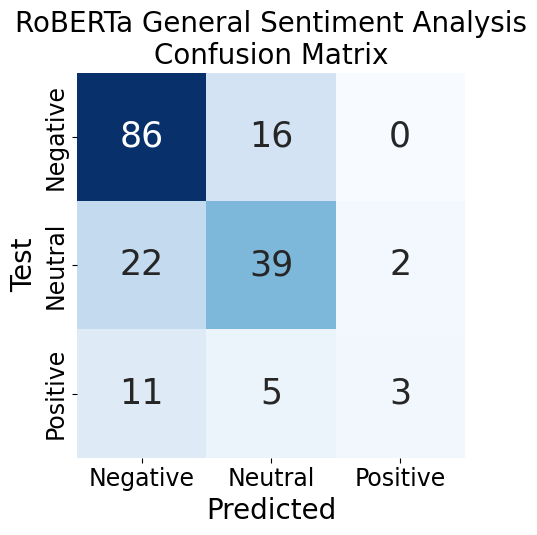

In [29]:
conf_matrix(label_list, pred_arr,'RoBERTa General Sentiment Analysis\nConfusion Matrix')

In [30]:
print(
    '\tClassification Report for RoBERTa:\n\n', 
    classification_report(
        label_list, 
        pred_arr, 
        target_names=['Negative', 'Neutral', 'Positive']
    )
)

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.72      0.84      0.78       102
     Neutral       0.65      0.62      0.63        63
    Positive       0.60      0.16      0.25        19

    accuracy                           0.70       184
   macro avg       0.66      0.54      0.55       184
weighted avg       0.69      0.70      0.67       184

